### Amazon Textract - Receipts Demo

In the following notebook, we will examine the use of Amazon Textract in order to perform optical character recognition (OCR), and then use Amazon Machine Learning to organize the dataset.

### General Imports

These are the libraries which we will require in order to complete different types of operations.

Just a quick note, you may need to use ```nltk.download()``` in order to download the correct libraries and additional packages required to perform text tagging

In [63]:
import boto3
import sagemaker
import sys
import os
import re
import numpy as np
import pandas as pd
import subprocess
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
import gzip
from io import BytesIO
import zipfile
import random
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import classification_report
from sklearn.preprocessing import normalize
from sklearn.manifold import TSNE
from matplotlib import pylab
import nltk 
import spacy
import en_core_web_lg
from datetime import datetime
from wordcloud import WordCloud, STOPWORDS
from nltk.stem import PorterStemmer 
import string
import pickle
from nltk.corpus import stopwords 
from itertools import combinations 
import operator
from io import BytesIO
import tarfile


### Constant Set-up
Configure all global constants here, these are variables which will remain constant throughout the execution of the notebook.

In [3]:
configs = {
    'aws_region' :  'us-east-1',
    'bucket_name': 'aws-demo-receipts',
    'prefix' : 'preprocessed_reviews', #only use this if you want to have your files in a folder 
    'dataset_path_s3' : 'receipts_data/',
    'training_data_prefix_s3' : 'training_data/',
    'output_data_s3' : 'output_data/',
    'dataset_zipped_filename': 'large-receipt-image-dataset-SRD.zip',
    'dataset_zipped_path':'data_zipped/',
    'tmp_folder':'tmp/',
    'stopwords_custom': 'stopwords_custom.txt'
   
}

global_vars = {}


### Environment Setup

Setting up the environment involves ensuring all the corret session and IAM roles are configured. We also need to ensure the correct region and bucket is made available.

In [4]:
def setup_env(configs, global_vars):
   
    sess = sagemaker.Session()
    
    role = get_execution_role()

    AWS_REGION = configs['aws_region']
    s3 = boto3.resource('s3')

    s3_bucket = s3.Bucket(configs['bucket_name'])

    if s3_bucket.creation_date == None:
    # create S3 bucket because it does not exist yet
        print('Creating S3 bucket {}.'.format(bucket))
        resp = s3.create_bucket(
            ACL='private',
            Bucket=bucket
        )
    else:
        print('Bucket already exists')
        
    global_vars['role'] = role
    global_vars['sess'] = sess
    global_vars['s3'] = s3
    global_vars['s3_bucket'] = s3_bucket
    
    
    #set up textract
    textract = boto3.client('textract')
    
    global_vars['textract'] = textract

    
    return global_vars

global_vars = setup_env(configs, global_vars)

Bucket already exists


In [22]:
def setup_nlp(configs, global_vars):
    
    nlp = en_core_web_lg.load()
    global_vars['nlp'] = nlp
    stop_words = []
    with open(configs['stopwords_custom'], 'r') as file:
        for line in file:
            stop_words.append(line.strip())
    global_vars['stop_words'] = stop_words
    return global_vars

global_vars = setup_nlp(configs, global_vars)

## Part 1. Download Data and Perform OCR using Amazon TExtract

Here we are goin to download the data to our bucket if it does not already exist. This dataset is a pre-compiled dataset of car images which contain 2 typers:

- Whole (e.g. without damage)
- Damaged (e.g. those with damage)

The following create_dataset method will first download the Zip of the data, and then unpack it to the bucket named in the global constants



In [4]:
def create_dataset(configs, global_vars):
    
    dataset_key = configs['dataset_path_s3']
    s3_bucket = global_vars['s3_bucket']
    objs = list(s3_bucket.objects.filter(Prefix=dataset_key))

    if len(objs) > 0 and objs[0].key == configs['dataset_zipped_filename']:
        exists = True
        print('{} Already Exists, No need to copy to S3 or Unzip'.format(dataset_key) )
    else:
        exists = False
    
    if not exists:
        
        data_path = configs['dataset_zipped_path'] + configs['dataset_zipped_filename']
        data_file_s3 = configs['dataset_path_s3'] + configs['dataset_zipped_filename']
        s3_bucket.upload_file(data_path, data_file_s3)

        s3 = boto3.client('s3', use_ssl=False)
        Key_unzip = configs['dataset_path_s3']

    
        s3_resource = boto3.resource('s3')
        #Now create zip object one by one, this below is for 1st file in file_list
        zip_obj = s3_resource.Object(bucket_name=bucket_name, key=data_file_s3)
        
        print('Unpacking {}\n'.format(data_file_s3))
        print (zip_obj)
        buffer = BytesIO(zip_obj.get()["Body"].read())
        z = zipfile.ZipFile(buffer)
        for filename in z.namelist():
            file_info = z.getinfo(filename)
            s3_resource.meta.client.upload_fileobj(
                z.open(filename),
                Bucket=bucket_name,
                Key=Key_unzip + f'{filename}')
            
        
    
# create_dataset(bucket_name, s3_bucket)

In [6]:
def test_textract(configs, global_vars, show_image = False):
    
    #first download a temp document
    tmp_folder = configs['tmp_folder']
    try:
        os.mkdir(tmp_folder)
    except:
        pass
    
    s3_bucket = global_vars['s3_bucket']
    s3 = global_vars['s3']
    
    s3_path = configs['dataset_path_s3']
    objs = list(s3_bucket.objects.filter(Prefix=s3_path))
    
    files_data = {}
    for entry in objs:
        print(entry.key)
        file_data = []
        if 'jpg' in entry.key:
            local_path = tmp_folder + 'tmp.jpg'
            s3.Bucket(configs['bucket_name']).download_file(str(entry.key), local_path)  
            
            with open(local_path, 'rb') as document:
                imageBytes = bytearray(document.read())
            
            response = global_vars['textract'].detect_document_text(Document={'Bytes': imageBytes})

            if show_image:
                raw_img = mpimg.imread(local_path)
                height, width, depth = raw_img.shape
                dpi = 80
                figsize = width / float(dpi), height / float(dpi)
                plt.figure(figsize = figsize)
                plt.imshow(raw_img, aspect='auto')

            files_data[entry.key] =  response
            
    return files_data


    
    
textract_data = test_textract(configs, global_vars)

receipts_data/
receipts_data/1000-receipt.jpg
receipts_data/1001-receipt.jpg
receipts_data/1002-receipt.jpg
receipts_data/1003-receipt.jpg
receipts_data/1004-receipt.jpg
receipts_data/1005-receipt.jpg
receipts_data/1006-receipt.jpg
receipts_data/1007-receipt.jpg
receipts_data/1008-receipt.jpg
receipts_data/1009-receipt.jpg
receipts_data/1010-receipt.jpg
receipts_data/1011-receipt.jpg
receipts_data/1012-receipt.jpg
receipts_data/1013-receipt.jpg
receipts_data/1014-receipt.jpg
receipts_data/1015-receipt.jpg
receipts_data/1016-receipt.jpg
receipts_data/1017-receipt.jpg
receipts_data/1018-receipt.jpg
receipts_data/1019-receipt.jpg
receipts_data/1020-receipt.jpg
receipts_data/1021-receipt.jpg
receipts_data/1022-receipt.jpg
receipts_data/1023-receipt.jpg
receipts_data/1024-receipt.jpg
receipts_data/1025-receipt.jpg
receipts_data/1026-receipt.jpg
receipts_data/1027-receipt.jpg
receipts_data/1028-receipt.jpg
receipts_data/1029-receipt.jpg
receipts_data/1030-receipt.jpg
receipts_data/1031-recei

### Useful Method if you want to resume a session if the kernal dies

In [8]:
def load_or_save_record_meta_data(textract_data=None, load_or_save='load'):
    
    tmp_filename = 'tmp.pickle'
    if load_or_save == 'load':
        with open(tmp_filename, 'rb') as handle:
            data = pickle.load(handle)
        return data

        
    if load_or_save == 'save':
        with open(tmp_filename, 'wb') as handle:
            pickle.dump(textract_data, handle, protocol=pickle.HIGHEST_PROTOCOL)  
        print('Saved to {}'.format(tmp_filename))
        return textract_data
    
textract_data = load_or_save_record_meta_data('', 'load')

## Part 2. Dataset Enrichment and Exploration

In this section, we're going to be exploring different analytical approaches to interpretting the receipt data. This is an important part of any data science driven experiment, as the exploration (and through the iterations of exploration), will help us derive the most useful insights for a given use case.

In [9]:
def inspect_dataset(textract_data):
    
    print('Total Records {}'.format(len(textract_data)))

inspect_dataset(textract_data)

Total Records 200


### 2.1 Process Data

Using Textract's repsponse, we look at each word in our data, and store it with it's confidence scores. Then a series of data enrichment processes take place.

Note, we use a filtering approach to ensure that we are not introducing random stop words..

#### Enriching the Textract Results

The Following methods will be used to enrich each of the records with additional information.

We're going to use two libraries to perform our enrichment, ```NLTK```, and ```Spacy```.

#### Part of Speech Tagging (POS)

In the world of Natural Language Processing (NLP), the most basic models are based on Bag of Words. But such models fail to capture the syntactic relations between words. ... POS tagging is the process of marking up a word in a corpus to a corresponding part of a speech tag, based on its context and definition.

For Part of Speak Tagging, we're using NLTK. More details can be found here:

https://www.nltk.org/api/nltk.tag.html

The tags which NLTK uses are as follows:

 - CD - cardinal numbers
 - AT -Articles
 - JJ - Adjectives
 - NN Nouns
 - NNS - Plural Nouns
 - RB - adverbs
 - VGB - gerunds
 - VBD - past tense verbs
 
#### Named Entity Recognition (NER)

Named-entity recognition (NER) (also known as entity identification, entity chunking and entity extraction) is a subtask of information extraction that seeks to locate and classify named entity mentioned in unstructured text into pre-defined categories such as person names, organizations, locations, medical codes, time expressions, quantities, monetary values, percentages, etc.

For our NER, spaCy features an extremely fast statistical entity recognition system, that assigns labels to contiguous spans of tokens. The default model identifies a variety of named and numeric entities, including companies, locations, organizations and products.

For More information on Spacey, please take a read here:



The Tags which Space use are as follows:

 - PERSON	People, including fictional.
 - NORP	Nationalities or religious or political groups.
 - FAC	Buildings, airports, highways, bridges, etc.
 - ORG	Companies, agencies, institutions, etc.
 - GPE	Countries, cities, states.
 - LOC	Non-GPE locations, mountain ranges, bodies of water.
 - PRODUCT	Objects, vehicles, foods, etc. (Not services.)
 - EVENT	Named hurricanes, battles, wars, sports events, etc.
 - WORK_OF_ART	Titles of books, songs, etc.
 - LAW	Named documents made into laws.
 - LANGUAGE	Any named language.
 - DATE	Absolute or relative dates or periods.
 - TIME	Times smaller than a day.
 - PERCENT	Percentage, including ”%“.
 - MONEY	Monetary values, including unit.
 - UANTITY	Measurements, as of weight or distance.
 - ORDINAL	“first”, “second”, etc.
 - CARDINAL	Numerals that do not fall under another type.



In [10]:
def process_textract_text(data, print_output= True):
    
    currencies = ['$',' £','€']
    
    values = []
    currency_values = []
    
    words = []
    
    UPPER_BOUND = 2000.0
    
    for line in data:
        #first see if it can be recognised as a value:
        if any(ext in line for ext in currencies):
            currency_values.append(line)
#             print(line)
        else:
            try:
                value = float(line)
                values.append(value)
            except:
                pass
            
        #now P O W taggig
        wrds = nltk.word_tokenize(line)
        words = words + wrds
    
    #nltk POS tagging
    nltk_tagged_words = nltk.pos_tag(words)
    
    #perform Spacy Analysis:
    spacey_enriched_words = spacey_enricher(global_vars, data)
    
    verbs = []
    nouns = []
    cds = []
    products = []
    locations = []
    organisations = []
    dates = []
    for entry in nltk_tagged_words:
#         print(entry)
        k = entry[0]

        v = entry[1]
        if v == 'NN' or v == 'NNS':
            nouns.append(k)
            
        if v == 'VBD' or v == 'VGB':
            verbs.append(k)
        
        if v == 'CD':
            cds.append(k)  
            
           
    #process SPACEY results
    for entry in spacey_enriched_words.ents:
        if entry.label_ is 'PRODUCT':
            products.append(entry.text)
        
        if entry.label_ is 'LOC':
            locations.append(entry.text)
        
        if entry.label_ is 'ORG':
            organisations.append(entry.text)
            
#         if entry.label_ is 'DATE':
#             dates.append(entry.text)
                    
    #calculate max cardinal values
    cds_float = []
    for value in cds:
        #firsr monetary values
        try:
            if ('.' in value):
                tmp = float(value)
                if tmp < UPPER_BOUND:
                    cds_float.append(tmp) 
        except:
            pass
       
        #now dates
        try:
            date_tmp = pd.to_datetime(str(value))
            #avoid the case where the hh:mm:ss is only found, and then pandas creates a date which is current day
            if date_tmp.date() != datetime.today().date():
                dates.append(str(date_tmp))
        except Exception as e:
            pass
            
    record_data = {}
    record_data['verbs'] = verbs
    record_data['nouns'] = nouns
    record_data['cardinals'] = cds
    record_data['products'] = products
    record_data['companies'] = organisations
    record_data['locations'] = locations
    record_data['dates'] = dates
    record_data['currency_values'] = dates
    record_data['values_raw'] = values
    record_data['tokens'] = words
    


    if len(cds_float) > 0:
        record_data['max_value'] = max(cds_float)
    else:
        record_data['max_value'] = 0


    
    if print_output:
         
        print('Currency Linked Value: {}'.format(currency_values))
        print('Raw Values: {}'.format(values))
    #     print('Tagged Words: {}'.format(nltk_tagged_words))
        print('Verbs: {}'.format(verbs))
        print('Nouns: {}'.format(nouns))
        print('Cardinal Values: {}'.format(cds))
        print('Products {}'.format(products))
        print('Companies {}'.format(organisations))
        print('Locations {}'.format(locations))
        print('Dates {}'.format(dates))
        print('MAX Value {}'.format( record_data['max_value']))
        print('\n ### \n')

    return record_data
    
        
    


In [11]:
def spacey_enricher(global_vars, words_list):
    string_of_words = ' '.join(map(str, words_list)) 
    
    string_of_words = string_of_words
#     print(string_of_words)
    doc = global_vars['nlp'](string_of_words)
    #returned with a list of entities (ents), which have k,v of (text, label_)
#     print([(X.text, X.label_) for X in doc.ents])
    return doc

In [23]:
def process_textract_responses(global_vars, data):
    stop_words = global_vars['stop_words']
    stop_words_nltk = stopwords.words('english')
    ps = PorterStemmer()
    exclude = set(string.punctuation)
    table = str.maketrans('', '', string.punctuation)

    records_enriched = {}
    removed_tokens = 0
    for key,response in data.items():
        line_data = []
        confidences = []
        for item in response["Blocks"]:
                if item["BlockType"] == "WORD":
                    
                    #we need to normailise and remove punctuation.
                    word = item["Text"].lower().strip()
                   
                    
    
                    #now remove all punctuation
                    word = word.translate(table)
            
                    word_stemmed = ps.stem(word)
                
                    #we have some oddities
                    word =  ' '.join(i for i in word.split(' ') if not i.endswith('pm'))
                    word  = ' '.join(i for i in word.split(' ') if not i.endswith('am'))
                    
                    if (word not in stop_words) and (word_stemmed not in stop_words) and (word_stemmed not in stop_words_nltk):
                        #first stem the word
                        
                        #final some last checks
                        if (word.isspace() == False) and (len(word) > 1):
                        
                            line_data.append(word_stemmed)
                            confidences.append({'word':word_stemmed,'confidence':item['Confidence']})
                    else:
                        removed_tokens += 1
                    
        #now we have the data
        record_data = process_textract_text(line_data, False)
        record_data['word_confidences'] = confidences
        records_enriched[key] = record_data
    
    print('Text Enrichment Finished. {} Records processed, {} Tokens removed'.format(len(records_enriched), removed_tokens)) 
    return records_enriched
    
records_enriched = process_textract_responses(global_vars, textract_data)

Text Enrichment Finished. 200 Records processed, 3102 Tokens removed


### 2.2 Basic Analysis of Enriched Results

Total Non-unique Tokens 8466
Unique Tokens 4680
Top 10 Common Tokens ['000', 'ca', '1200', 'chicken', 'fri', '10', 'ny', '12', '600', '1000']


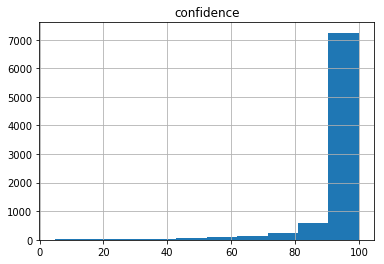

In [24]:
def analyse_records(records_enriched, word_cloud=False):
    

    words_conf = []
    dates = []
    #raw data
    for key,data in records_enriched.items():
        
#         print(data['max_value'])
        words_conf = words_conf + data['word_confidences']
        dates = dates + data['dates']
        
    #let's look at the distribution of confidence scores.    
    df_words = pd.DataFrame(words_conf)
    
    print('Total Non-unique Tokens {}'.format(df_words.shape[0]))
    print('Unique Tokens {}'.format(df_words['word'].unique().shape[0]))
    n = 10
    top_n_terms = df_words['word'].value_counts()[:n].index.tolist()
    print('Top {} Common Tokens {}'.format(n, top_n_terms))

    df_words.hist()

    words_list_non_unique = df_words['word'].tolist()
    
    
    #Simple word cloud to view our data.
    if word_cloud:
        string_of_words = ' '.join(map(str, words_list_non_unique)) 
        wordcloud = WordCloud(
            width = 3000,
            height = 2000,
            background_color = 'black',
            stopwords = STOPWORDS).generate(string_of_words)
        fig = plt.figure(
        figsize = (40, 30),
        facecolor = 'k',
        edgecolor = 'k')
        plt.imshow(wordcloud, interpolation = 'bilinear')
        plt.axis('off')
        plt.tight_layout(pad=0)
        plt.show()

#         df_dates = pd.DataFrame(dates)
#         df_dates.plot()

    return df_words
df_words = analyse_records(records_enriched, word_cloud=False)

### 2.3 Token Co-Occurrence

It might be quite nice to understand the co-occurance of items within receipts.

For those who have worked in this space before, we can used SVD techniques to calculate the co-occurance, or libraries such as GloVe, which uses Vector Spaces of word representations in order to analyse the tokens. 

For this example, we're going to start off with a very simple counter based approach


In [35]:
def token_coocurance(records_enriched, combination_size = 2):
    
    cooc_counts = {}
    for key,data in records_enriched.items():
        
        tokens = data['tokens']
        cleaned = [ x for x in tokens if not x.isdigit() ]
        #remove dups
        cleaned =  list(dict.fromkeys(cleaned))
        cooc = list(combinations(cleaned, combination_size)) 
        
        for occ in cooc:
            if occ in cooc_counts:
                cnt = cooc_counts[occ]
                cooc_counts[occ] = cnt +1
            else:
                cooc_counts[occ] = 1
    
    print('Total Unique Token Co-Occurrences {}'.format(len(cooc_counts)))
    cooc_counts_sorted = dict( sorted(cooc_counts.items(), key=operator.itemgetter(1),reverse=True))
    top_k = 50
    cnt = 0
    
   
         
    min_cooc_cnt = 3   
    cooc_counts_sorted_filtered = {key:val for key, val in cooc_counts_sorted.items() if val > min_cooc_cnt}

    for k,v in cooc_counts_sorted_filtered.items():
        if cnt < top_k:
            print(k, v)
            cnt+= 1
            
    print('Filtered (min count {}) Unique Token Co-Occurrences {}'.format(min_cooc_cnt, len(cooc_counts_sorted_filtered)))
        

token_coocurance(records_enriched, combination_size = 2)  

Total Unique Token Co-Occurrences 58840
('ca', 'fri') 8
('parti', 'svrck') 7
('ca', 'coke') 6
('ca', 'beef') 6
('chees', 'fri') 6
('park', 'ny') 6
('fri', 'rice') 6
('ca', 'dinner') 6
('ca', 'tender') 6
('ice', 'tea') 6
('beach', 'ca') 5
('miami', 'fl') 5
('ca', 'drink') 5
('san', 'ca') 5
('ca', 'id') 5
('french', 'fri') 5
('chicken', 'rice') 5
('ny', 'coffe') 5
('ca', 'custom') 5
('new', 'york') 5
('ca', 'coffe') 4
('drive', 'thru') 4
('settl', 'tender') 4
('ny', 'sp') 4
('diet', 'coke') 4
('oak', 'ca') 4
('ca', 'soda') 4
('cafe', 'ca') 4
('ca', 'tbl') 4
('new', 'ny') 4
('fri', 'onion') 4
('taco', 'de') 4
('jericho', 'ny') 4
('ca', 'grill') 4
('grill', 'fri') 4
('avenu', 'side') 4
('ny', 'side') 4
('acct', 'auth') 4
('ca', 'regular') 4
('mexican', 'chicken') 4
('chicken', 'subtota') 4
('custom', 'copi') 4
('ca', 'chicken') 4
('ca', 'aid') 4
('ny', 'chicken') 4
('sauc', 'fri') 4
('chicken', 'beef') 4
('beach', 'fl') 4
Filtered (min count 3) Unique Token Co-Occurrences 48


### 2.4 Word Embeddings 

Another approach is to examine the word embeddings of the text in order to determine relationships between the terms (tokens) within the data.

Word2Vec is a popular algorithm used for generating dense vector representations of words in large corpora using unsupervised learning. The resulting vectors have been shown to capture semantic relationships between the corresponding words and are used extensively for many downstream natural language processing (NLP) tasks like sentiment analysis, named entity recognition and machine translation.

In order to acheive this, we're going to be using SageMaker's ```blazingtext``` estimator.



In [69]:
def prep_data_form_sagemaker_training(configs, global_vars, records_enriched):
    
    tokens = []
    #raw data
    for key,data in records_enriched.items():
        
#         print(data['max_value'])
        tokens = tokens + data['tokens']
    
    cleaned = [ x for x in tokens if not x.isdigit() ]

    corpus = ' '.join(map(str, cleaned)) 
    print('Total Corpus Size: {} Tokens'.format(len(tokens)))
    print('Total Char Size: {} '.format(len(corpus)))
    
    return corpus
    
    
corpus = prep_data_form_sagemaker_training(configs, global_vars, records_enriched)    

Total Corpus Size: 8516 Tokens
Total Char Size: 32164 


In [70]:
def upload_corpus_to_s3(configs, global_vars, corpus):
    
         
    dataset_key = 'train'
    s3_bucket = global_vars['s3_bucket']
    
    sess = global_vars['sess']
    bucket = global_vars['s3_bucket']
    
    with open(dataset_key, 'w') as f:
        f.write(corpus)
   
        
    data_file_s3 = configs['training_data_prefix_s3'] + dataset_key
    s3_bucket.upload_file(dataset_key, data_file_s3)   

    s3_train_data = 's3://{}/{}'.format(configs['bucket_name'], configs['training_data_prefix_s3'])
    s3_output_location = 's3://{}/output'.format(configs['bucket_name'])
    configs['s3_train_data'] = s3_train_data
    configs['s3_output_location'] = s3_output_location

    print('S3 Training Data Path {}'.format(s3_train_data))
    print('S3 Training Data Path {}'.format(s3_output_location))

    return configs
configs = upload_corpus_to_s3(configs, global_vars, corpus) 

S3 Training Data Path s3://aws-demo-receipts/training_data/
S3 Training Data Path s3://aws-demo-receipts/output


In [71]:
def configure_estimator(configs, global_vars):
    
    region_name = configs['aws_region'] 
    sess = global_vars['sess']
    container = sagemaker.amazon.amazon_estimator.get_image_uri(region_name, "blazingtext", "latest")
    print('Using SageMaker BlazingText container: {} ({})'.format(container, region_name))

    bt_model = sagemaker.estimator.Estimator(container,
                                         global_vars['role'], 
                                         train_instance_count=2, 
                                         train_instance_type='ml.c4.2xlarge',
                                         train_volume_size = 5,
                                         train_max_run = 360000,
                                         input_mode= 'File',
                                         output_path=configs['s3_output_location'],
                                         sagemaker_session=sess)
    
    bt_model.set_hyperparameters(mode="batch_skipgram",
                             epochs=5,
                             min_count=5,
                             sampling_threshold=0.0001,
                             learning_rate=0.05,
                             window_size=5,
                             vector_dim=100,
                             negative_samples=5,
                             batch_size=11, #  = (2*window_size + 1) (Preferred. Used only if mode is batch_skipgram)
                             evaluation=True,# Perform similarity evaluation on WS-353 dataset at the end of training
                             subwords=False) # Subword embedding learning is not supported by batch_skipgram
    
    train_data = sagemaker.session.s3_input(configs['s3_train_data'], distribution='FullyReplicated', 
                        content_type='text/plain', s3_data_type='S3Prefix')

    data_channels = {'train': train_data}
    
   
    global_vars['train_data'] = train_data
    global_vars['data_channels'] = data_channels
    global_vars['bt_model'] = bt_model
    
    return global_vars

global_vars = configure_estimator(configs, global_vars)

Using SageMaker BlazingText container: 811284229777.dkr.ecr.us-east-1.amazonaws.com/blazingtext:latest (us-east-1)


In [72]:
def fit_model(configs, global_vars):
    
    bt_model = global_vars['bt_model']
    data_channels = global_vars['data_channels']
    bt_model.fit(inputs=data_channels, logs=True)
    
    
fit_model(configs, global_vars)

2020-03-18 07:19:51 Starting - Starting the training job...
2020-03-18 07:19:52 Starting - Launching requested ML instances......
2020-03-18 07:20:57 Starting - Preparing the instances for training...
2020-03-18 07:21:50 Downloading - Downloading input data...
2020-03-18 07:22:21 Training - Training image download completed. Training in progress..Arguments: train
Found 10.2.146.105 for host algo-1
Found 10.2.160.144 for host algo-2
Arguments: train
Found 10.2.146.105 for host algo-1
Found 10.2.160.144 for host algo-2
[03/18/2020 07:22:34 WARNING 140452868884288] Loggers have already been setup.
[03/18/2020 07:22:34 WARNING 140452868884288] Loggers have already been setup.
[03/18/2020 07:22:34 INFO 140452868884288] nvidia-smi took: 0.0251801013947 secs to identify 0 gpus
[03/18/2020 07:22:34 INFO 140452868884288] Running distributed CPU BlazingText training using batch_skipgram on 2 hosts.
[03/18/2020 07:22:34 INFO 140452868884288] Number of hosts: 2, master IP address: 10.2.146.105, ho

In [59]:
def host_endpoint(configs, global_vars):
        
    bt_model = global_vars['bt_model']

    bt_endpoint = bt_model.deploy(initial_instance_count = 1,instance_type = 'ml.m4.xlarge')

    global_vars['bt_endpoint']  = bt_endpoint 
    return global_vars
    
# global_vars = host_endpoint(configs, global_vars)

---------------!

In [73]:
def download_model_results(configs, global_vars):
    
    bt_model = global_vars['bt_model']
    s3 = global_vars['s3']
    bucket_name = configs['bucket_name']
    model_filename = 'model.tar.gz'
    key = bt_model.model_data[bt_model.model_data.find("/", 5)+1:]
    s3.Bucket(bucket_name).download_file(key, model_filename )

    #untar file
    tar = tarfile.open(model_filename)
    tar.extractall()
    tar.close()

download_model_results(configs, global_vars)


In [96]:
def evaluate_model_results():
    num_points = 150

    first_line = True
    index_to_word = []
    cnt  = 0
    with open("vectors.txt","r") as f:
        for line_num, line in enumerate(f):
            if first_line:
                dim = int(line.strip().split()[1])
                word_vecs = np.zeros((num_points, dim), dtype=float)
                first_line = False
                continue
            line = line.strip()
            word = line.split()[0]
            vec = word_vecs[line_num-1]
            for index, vec_val in enumerate(line.split()[1:]):
                vec[index] = float(vec_val)
            index_to_word.append(word)
            if line_num >= num_points:
                break
            cnt +=1
    word_vecs = normalize(word_vecs, copy=False, return_norm=False)
    print('Total Vector Space {}'.format(cnt))

    tsne = TSNE(perplexity=80, n_components=2, init='pca', n_iter=10000, verbose=1)
    two_d_embeddings = tsne.fit_transform(word_vecs[:num_points])
    labels = index_to_word[:num_points]
    
    print('Total Tokens {}'.format(len(labels)))
    
    return two_d_embeddings, labels

two_d_embeddings, labels = evaluate_model_results()

Total Vector Space 149
[t-SNE] Computing 149 nearest neighbors...
[t-SNE] Indexed 150 samples in 0.000s...
[t-SNE] Computed neighbors for 150 samples in 0.006s...
[t-SNE] Computed conditional probabilities for sample 150 / 150
[t-SNE] Mean sigma: 0.413534
[t-SNE] KL divergence after 250 iterations with early exaggeration: 46.543831
[t-SNE] KL divergence after 750 iterations: 0.540162
Total Tokens 150


#### Plotting Embeddings
 t-SNE and Word2Vec are stochastic, so although when you run the code the plot won’t look the same everytime the methods are executed

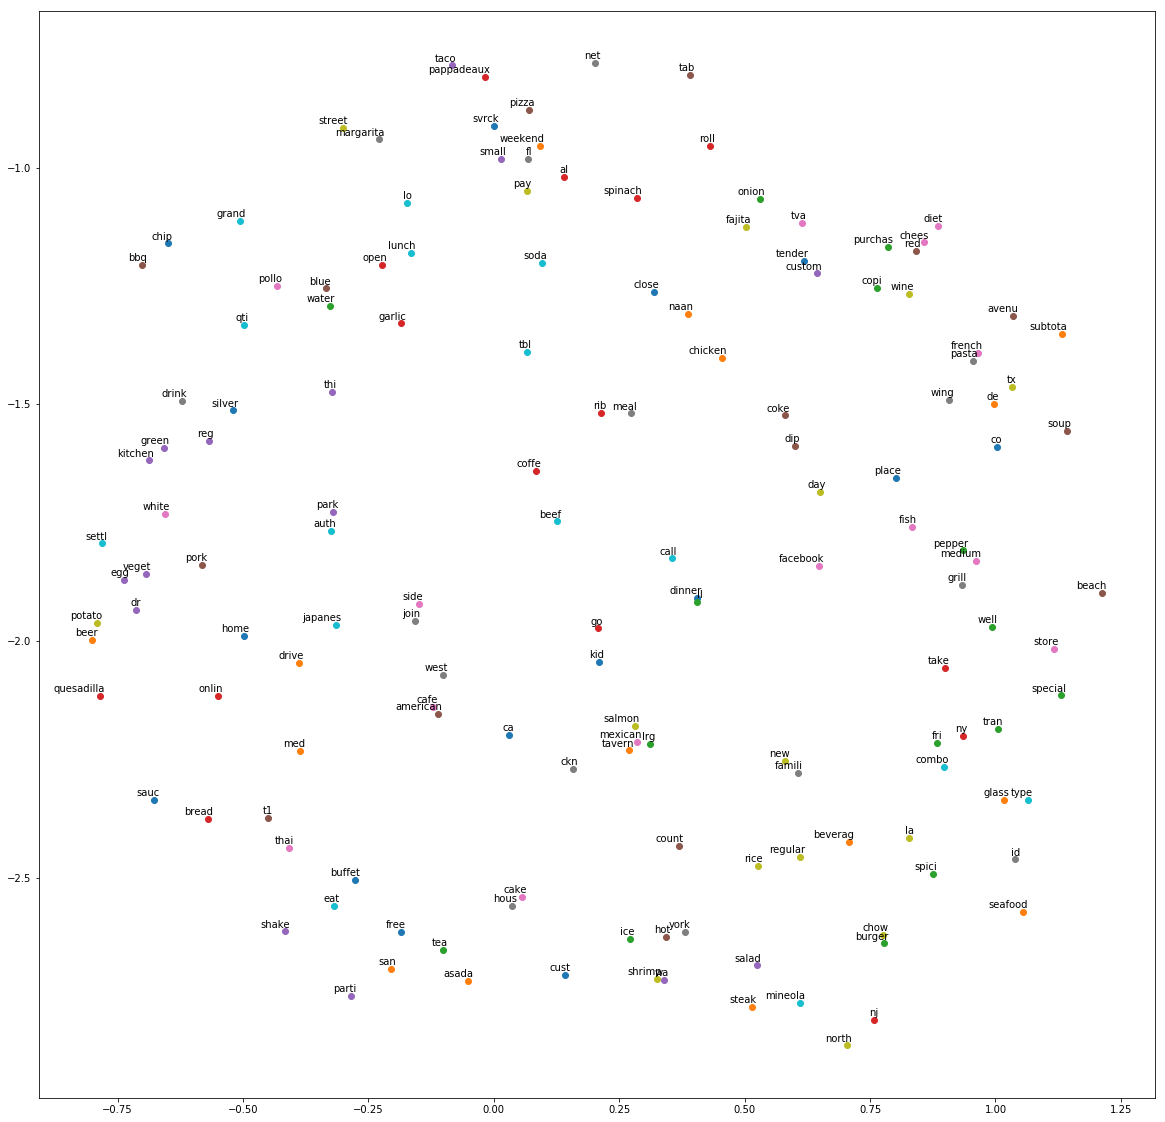

In [97]:
def plot(embeddings, labels):
    pylab.figure(figsize=(20,20))
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                       ha='right', va='bottom')
    pylab.show()

plot(two_d_embeddings, labels)

Notes: Compared to the Word Co-Occurence Approach, work embeddings usign Skip-Grams provide an abstraction of tokens within a given vector space, which allows for relationships between different words to be exposed! We can see from the results, we are seeing words such as Pasta, Pizza, and Cheese occuring within the same vector space, for instance. Pretty good considering the tokens used to build our embeddings was extremely small!
